In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty
from sklearn.linear_model import LinearRegression

In [4]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [5]:
df_mess_train.loc[df_mess_train['objid'] == '573c0cd0f0fe6e735a699b93']

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.0,1.463553e+12,39.732045,-104.973651


In [4]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [5]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [6]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [7]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [10]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):

    df_feat = df_mess_train.pivot_table(values='rssi', index='objid', columns='bsid', 
                         aggfunc=lambda x: min(x))
    return df_feat

In [11]:
df_feat = feat_mat_const(df_mess_train, listOfBs)

In [52]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):
    new_pos = pos_train.set_index(df_mess_train.objid)
    new_pos = new_pos.groupby(new_pos.index).first()
    ground_truth_lat = new_pos.lat
    ground_truth_lng = new_pos.lng
    return ground_truth_lat, ground_truth_lng

In [53]:
df_feat = feat_mat_const(df_mess_train, listOfBs)
df_feat.head()

bsid,879,911,921,944,980,1012,1086,1092,1120,1148,...,8747,9784,9899,10134,10148,10151,10162,10999,11007,11951
objid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573bf3533e952e19126b256a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573c0cd0f0fe6e735a699b93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573c1272f0fe6e735a6cb8bd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573c8ea8864fce1a9a5fbf7a,NaN,NaN,NaN,NaN,NaN,NaN,-141.0,NaN,NaN,NaN,...,NaN,NaN,-129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

In [48]:
df_feat.shape

(6068, 251)

In [69]:
np.array(df_feat.iloc[3034:,].replace(np.nan, 0))

array([[   0.,    0.,    0., ...,    0., -120.,    0.],
       [   0.,    0.,    0., ...,    0., -124.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ..., 
       [   0.,    0.,    0., ...,    0., -121.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [44]:
# Validation

In [74]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    
    model = LinearRegression()
    model.fit(np.array(df_feat.iloc[3034:,].replace(np.nan, 0)), np.array(ground_truth_lat.iloc[3034:,]))
    y_pred_lat = model.predict(np.array(df_feat.iloc[:3034,].replace(np.nan, 0)))
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    
    return y_pred_lat#, y_pred_lng


In [75]:
pred_lat = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_mess_test)

In [82]:
pd.DataFrame(pred_lat, ground_truth_lat.iloc[:3034,])

,0
lat,
39.606690,3.973100e+01
39.637741,3.974262e+01
39.730417,3.872040e+09
39.693102,3.970553e+01
39.758167,9.299444e+09
39.753402,3.965702e+01
39.752205,3.725372e+09
39.658836,3.974193e+01
39.750828,3.334257e+09


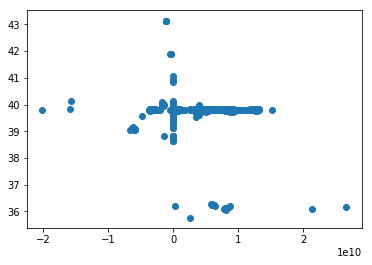

In [81]:
plt.scatter(pred_lat, ground_truth_lat.iloc[:3034,])


In [134]:
# Make regressor and prediction using the train set

In [146]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

In [136]:
# Cross validation

In [139]:
# Evaluate result

In [140]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [141]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [147]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [148]:
# Plot error distribution

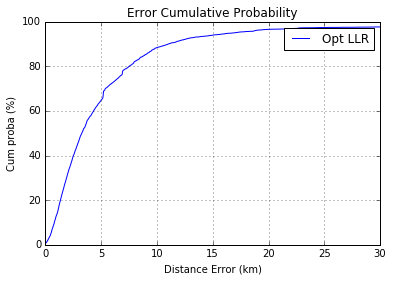

In [149]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [150]:
# Error criterion

np.percentile(err_vec, 80)

7522.0667120795024

In [151]:
# Construct test prediction

In [152]:
df_mess_test.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539,2,-111,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504,0,-136,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504,0,-127,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504,0,-129,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504,0,-105,1.463551e+12,39.783211,-105.088747


In [153]:
df_feat_test = feat_mat_const(df_mess_test, listOfBs)

In [154]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

In [155]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])

In [156]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [157]:
test_res.head()

,lat,lng
0,39.772921,-105.049617
1,39.774793,-105.062468
2,39.678762,-105.012780
3,39.773710,-105.037452
4,39.678762,-105.012780
